# Perform repetition narrowing analyses in pre and post lockdown infants

This notebook performs analyses on data from a repetition suppression task to look at face processing and recreates figures in the manuscript. It uses files created from various scripts as described in the README and preprocessed data, assumed to be saved in `data/RepetitionNarrowing/`.

Note: p values may differ from those reported in the manuscript because of random seeds.

**Table of Contents**
>[Set up](#setup)  
>[Participant summary information](#descriptives)     
>[Behavioral analyses](#behavior)  
>[Human face processing in infant FFA](#looFFA)  
>[Human face processing in broader ROIs](#human)  
>[Sheep face processing in broader ROIs](#sheep)  

## Set up <a id='setup'></a>

In [1]:
%matplotlib inline
%autosave 5

# suppress warning
import warnings 
warnings.filterwarnings('ignore')

# Import a bunch of stuff 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os
from os import path
import glob
from scipy import stats
from scipy.io import loadmat
from nilearn import plotting
from nilearn.input_data import NiftiMasker
import nibabel as nib



Autosaving every 5 seconds


In [2]:
# Get the base directory
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir) # Come back

# Set the data directories
behav_dir =  base_dir + 'data/RepetitionNarrowing/looking_behavior/'
roi_dir =  base_dir + 'data/RepetitionNarrowing/ROIs/' 
zstat_dir =  base_dir + 'data/RepetitionNarrowing/contrast_maps/'
loo_dir =  base_dir + 'data/RepetitionNarrowing/LOO_contrast_maps/'
save_plot_dir = base_dir + 'data/RepetitionNarrowing/plots/'

# What are the names of the meta-analysis ROIs?
rois=['bilateral_FFA','bilateral_OFA','bilateral_STS','bilateral_Amyg','rIFG_mask_1mm']

# plotting colors for face ROIS
colors=np.array([['darkslateblue','rebeccapurple','orchid','indianred','orange'],
               ['lightsteelblue','mediumpurple','plum','lightcoral','bisque']])

# What are the names of the control ROIs?
control_rois=['V1_sphere_1mm','bilateral_A1']

# plotting colors for control ROIs
control_colors=np.array([['teal','darkolivegreen'],
               ['mediumturquoise','olivedrab']])

# Which z stats are the most important here? 4- Novel 5- Repeat 1- Contrast of Novel - Repeat  
zstats=[4,5,1]

### Functions 
Define a bunch of functions that will be used in this notebook

In [3]:
def bootstrap_mean(data,null_vall=0,nPerm=1000):
    '''Bootstrap resampling for the mean of the data'''
    perm_dist=[]
    for perm in range(nPerm):
        sampidx=np.random.choice(np.arange(len(data)),len(data),replace=True)
        randomsamp=np.array(data)[sampidx]
        perm_dist.append(np.nanmean(randomsamp))
    
    # calculate 2 way pval
    if np.nanmean(data) < null_vall:
        pval=np.sum(np.array(perm_dist)>=null_vall)/nPerm*2
    else:
        pval=np.sum(np.array(perm_dist)<=null_vall)/nPerm*2
    
    CIs =[np.percentile(perm_dist, 2.5), np.percentile(perm_dist, 97.5)]
    
    # If the value is greater than 1 then subtract 2
    if pval > 1:
        pval = 2 - pval
          
    return pval, CIs

def randomise_diff_2sample(data_1, data_2, resample_num=1000):        
    '''Bootstrap resampling independent samples. 
    Take N samples with replacement from each group separately, average within group and then subtract. 
    Do this X times and report the p value of the number of samples in the opposite direction 
    from the true effect'''
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.mean(data_1[sub_idx_1]) - np.mean(data_2[sub_idx_2])]
    
    # calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) >= 0)) / (resample_num))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.mean(data_1) - np.mean(data_2)
    
    # return the difference in ROI and 
    return p_val, mean_diff, CIs

def draw_sig(pval,num_comp,xpos,ypos,subplot=False):
    '''Draw significance stars on a plot given the pval, number of comparisons and x and y positions'''
    if pval<0.001/num_comp:
        text='***'
    elif pval<0.01/num_comp:
        text='**'
    elif pval<0.05/num_comp:
        text='*'
    elif pval<0.1/num_comp:
        text='~'
    else:
        text=''
    
    if subplot==False:
        plt.annotate(text,(xpos,ypos),fontsize=14)
    else:
        subplot.annotate(text,(xpos,ypos),fontsize=14)

def mask_roi_contrasts(ppts,glm_contrast='human_pairs',zstats=zstats,roi_name='bilateral_FFA'):
    '''Mask a group of participant's data for a given GLM contrast and z-statistics using a given ROI '''
    
    # Which ROI do we want?
    intersect_mask_name=roi_dir+'intersect_'+roi_name+'.nii.gz'
    roi = nib.load(intersect_mask_name)
    masker=NiftiMasker(roi)
    mask_shape=masker.fit_transform(roi)

    # preset the data to be zstat values by number of participants
    data_all=np.zeros((len(zstats),len(ppts)))
    
    # cycle through zstats and ppts
    for z, zstat in enumerate(zstats):
        for p, ppt in enumerate(ppts):
            
            # Fit it to the subject's data 
            subdata=nib.load('%s/%s_%s_zstat%d.nii.gz' %(zstat_dir,ppt,glm_contrast,zstat))
            data_roi=masker.fit_transform(subdata)[0]
            
            # add the average across all voxels in this ROI 
            data_all[z,p]=np.nanmean(data_roi) 

    return data_all

def roi_results_wrapper(temp_rois=rois,temp_colors=colors,roi_group='face',glm_contrast='human_pairs',plot=True):
    ''' Wrapper function for ROI results that takes a list of rois (and plotting colors), 
    the name of that roi group, and the GLM contrast where the zstats will be coming from.
    For each ROI, the participant data is masked and re-grouped into pre and post-lockdown participants,
    then plotted using seaborn, and the statistics are reported 
    '''
        
    # preset pre and post lockdown results
    pre_lockdown_results=[]
    post_lockdown_results=[]
    
    print('Loading files for %s rois with %s contrast (may take some time)' %(roi_group,glm_contrast))
    
    # cycle through rois
    for roi_name in temp_rois:
        
        # Mask the data for these participants -- easier to use all of the participants now so we don't 
        # have to reload the same masks over again
        data=mask_roi_contrasts(np.array(df.ppt),
                               glm_contrast=glm_contrast,
                               zstats=zstats, # 4-novel, 5-repeat, 1-novel - repeat
                               roi_name=roi_name)
        
        # now we can save out the participant data in different arrays so we don't mix up pre and post groups
        pre_lockdown_results.append(data[:,pre_idxs])
        post_lockdown_results.append(data[:,post_idxs])
        
        print('Loaded %s' % roi_name)
        
    # Reshape the data so that it is in a plottable format 
    # now, we've also insured that all pre lockdown infants precede all post lockdown infants
    stacked_results=np.dstack((pre_lockdown_results,post_lockdown_results)) # ? ROIs x  3 zstats x 12 subjects 
    
    # Make a list of the group IDs the same length and order as stacked_results
    group_ids=np.hstack((np.repeat('pre_lockdown',np.stack(post_lockdown_results).shape[2]),
                       np.repeat('post_lockdown',np.stack(post_lockdown_results).shape[2])))
    
    # set seed for analyses
    np.random.seed(0)

    # preset results dict
    results_dict=dict()
    
    if plot==True:
        fig, ax = plt.subplots(1, len(temp_rois), figsize=(15, 5), sharey=True)
        ax[0].set_xlim(-0.5,1.5)
    
    print()
    
    # cycle through th ROIs for plotting and statistics
    for r, roi_name in enumerate(temp_rois):
        
        # preset
        data_all=[]
        zstats_all=[]
        groups_all=[]
        
        # cycle through the zstats
        for z, zstat in enumerate(zstats):

            # ONLY plot the repeat and novel and not their contrast
            if zstat!=1:
                data_all.extend(stacked_results[r,z,:]) # get the data for this roi and zstat
                zstats_all.extend(np.repeat(zstat,stacked_results.shape[2])) # save a list of the zstat name with the same length
                groups_all.extend(group_ids) # save a list of the group IDs with the same length

        # make the data frame for plotting
        neural_df=pd.DataFrame({'Data':data_all,'Group':groups_all,'Zstat':zstats_all})
        
        # save this for later! 
        results_dict[roi_name]=neural_df
                
        if plot==True:
            bar=sns.barplot(x='Group',y='Data',hue='Zstat',data=neural_df,ax=ax[r],
                        palette=temp_colors[:,r], alpha=0.8,ci=False)
            g=sns.swarmplot(x='Group',y='Data',hue='Zstat',data=neural_df,ax=ax[r],dodge=True,
                        palette=temp_colors[:,r], alpha=1)

            ax[r].get_legend().remove() # remove the legend
            ax[r].set_ylabel('')
            ax[r].set_title(roi_name)

        # Now report stuff
        print(roi_name)
        
        # pre lockdown group (using the zstat for the contrast)
        pre_lockdown_contrast=stacked_results[r,np.array(zstats)==1,group_ids=='pre_lockdown'] 
        pval,CIs=bootstrap_mean(pre_lockdown_contrast,null_vall=0,nPerm=1000)
        print('pre_lockdown: Novel > Repeat : %0.3f (%0.3f -- %0.3f), p=%0.3f' %(
            np.nanmean(pre_lockdown_contrast),CIs[0],CIs[1],pval))
        if plot==True:
            draw_sig(pval,1,0,2.5,subplot=ax[r])

        # post lockdown group (using the zstat for the contrast)
        post_lockdown_contrast=stacked_results[r,np.array(zstats)==1,group_ids=='post_lockdown']
        pval,CIs=bootstrap_mean(post_lockdown_contrast,null_vall=0,nPerm=1000)
        print('post_lockdown: Novel > Repeat : %0.3f (%0.3f -- %0.3f), p=%0.3f' %(
            np.nanmean(post_lockdown_contrast),CIs[0],CIs[1],pval))
        if plot==True:
            draw_sig(pval,1,1,2.5,subplot=ax[r])

        # difference contrast 
        pval, mean_diff, CIs=randomise_diff_2sample(pre_lockdown_contrast, post_lockdown_contrast, resample_num=10000)
        print('Difference across groups: %0.3f (%0.3f -- %0.3f), p=%0.3f' %(mean_diff,CIs[0],CIs[1],pval))
        if plot==True:
            draw_sig(pval,1,0.5,3,subplot=ax[r])
    
        print()
    
    if plot==True:
        plt.show()
        fig.savefig('%s/%s_rois_%s.svg' %(save_plot_dir,roi_group,glm_contrast))
    
    return results_dict

## Participant summary information <a id='descriptives'></a>

Load the participant information and report some summary statistics

In [4]:
df = pd.read_csv(base_dir + 'data/RepetitionNarrowing/participant_information.csv',index_col=0)
df

,ppt,Age,Sex,prop_TR_included,Human_Rep,Human_Nov,Sheep_Rep,Sheep_Nov,Scenes_Nov,Total_blocks,eye_reliability,coder_num,Post Lockdown Group,days_quarantine
0,s8687_1_5,17.1,F,1.000000,3,3,3,3,3,15,0.976324,2,0,0
1,s8687_2_1,10.7,F,0.974684,3,2,3,3,3,14,0.934509,2,1,244
4,s6687_1_5,18.1,F,1.000000,3,3,3,3,3,15,0.974043,2,0,0
5,s4607_1_4,13.0,F,0.982353,2,2,2,2,2,10,0.928697,2,0,0
6,s4607_1_6,16.9,F,1.000000,2,2,2,2,2,10,0.970920,2,0,0
15,s6057_1_6,23.8,M,1.000000,2,2,2,2,2,10,0.960978,2,1,213
21,s8037_1_2,12.2,F,0.976471,3,3,3,3,3,15,0.934036,2,0,0
29,s7067_1_3,9.2,F,1.000000,3,3,3,3,3,15,0.949309,3,0,0
39,s7047_1_2,17.6,F,1.000000,3,3,3,3,3,15,0.957972,2,1,216
45,s3097_1_4,13.4,F,0.865546,3,3,2,3,3,14,0.838029,2,1,185


In [5]:
# cycle through the two groups and report some averages
pre_idxs=(np.array(df['Post Lockdown Group'])==0)
post_idxs=(np.array(df['Post Lockdown Group'])==1)

names=['Pre lockdown group','Post lockdown group']

for i, ids in enumerate([pre_idxs,post_idxs]):
    
    print('Summary for %s:' %names[i])
    
    session_num=[]
    for sub in df.ppt[ids]:
        session_num.append(int(sub.split('_')[2]))
    print('Data collected on session 1 = %d; session 2 = %d; session 3+: %d' %(sum(np.array(session_num)==1),
                                                                              sum(np.array(session_num)==2),
                                                                               sum(np.array(session_num)>2)))
    print('Mean Age: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.Age[ids]),np.nanstd(df.Age[ids]),
    np.nanmin(df.Age[ids]),np.nanmax(df.Age[ids])))
    
    print('Mean Reliability: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.eye_reliability[ids]),np.nanstd(df.eye_reliability[ids]),
    np.nanmin(df.eye_reliability[ids]),np.nanmax(df.eye_reliability[ids])))
          
    print('Mean TRs included after motion: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.prop_TR_included[ids]),np.nanstd(df.prop_TR_included[ids]),
    np.nanmin(df.prop_TR_included[ids]),np.nanmax(df.prop_TR_included[ids]))) 
    
    print('Total number of blocks: M= %f SD = %f; range: %f -- %f' %(
    np.nanmean(df.Total_blocks[ids]),np.nanstd(df.Total_blocks[ids]),
    np.nanmin(df.Total_blocks[ids]),np.nanmax(df.Total_blocks[ids]))) 
    
    print()
    

Summary for Pre lockdown group:
Data collected on session 1 = 0; session 2 = 1; session 3+: 5
Mean Age: M= 14.416667 SD = 3.190306; range: 9.200000 -- 18.100000
Mean Reliability: M= 0.955555 SD = 0.019290; range: 0.928697 -- 0.976324
Mean TRs included after motion: M= 0.993137 SD = 0.009853; range: 0.976471 -- 1.000000
Total number of blocks: M= 13.333333 SD = 2.357023; range: 10.000000 -- 15.000000

Summary for Post lockdown group:
Data collected on session 1 = 2; session 2 = 2; session 3+: 2
Mean Age: M= 16.083333 SD = 4.250261; range: 10.700000 -- 23.800000
Mean Reliability: M= 0.932630 SD = 0.043196; range: 0.838029 -- 0.960978
Mean TRs included after motion: M= 0.953393 SD = 0.046490; range: 0.865546 -- 1.000000
Total number of blocks: M= 13.000000 SD = 2.160247; range: 10.000000 -- 15.000000



In [6]:
np.random.seed(0)
for val in ['Age','eye_reliability','prop_TR_included','Total_blocks']:  
    pval,mean_diff,_=randomise_diff_2sample(np.array(df[val][pre_idxs]),np.array(df[val][post_idxs]))
    print('Difference in pre and post for %s: %0.3f, pval=%0.3f' %(val,mean_diff,pval))        

Difference in pre and post for Age: -1.667, pval=0.442
Difference in pre and post for eye_reliability: 0.023, pval=0.214
Difference in pre and post for prop_TR_included: 0.040, pval=0.018
Difference in pre and post for Total_blocks: 0.333, pval=0.732


## Behavioral analyses <a id='behavior'></a>

First: did infants attend differently during the blocks? (i.e., was looking at the image during habituation similar across groups?) What about their motion specifically during these blocks? (The above values reflect proportion TR included after motion excluded when considering all block types)

In [7]:
# preset
behavior_group=dict()
tr_group=dict()

# what are the group indices?
group_idxs=[pre_idxs,post_idxs]

# cycle through groups and conditions 
for i, group in enumerate(['pre_lockdown','post_lockdown']):
    behavior_group[group]=dict()
    tr_group[group]=dict()
    
    for c, condition in enumerate(['Human_Adult; Novel','Human_Adult; Repeat']):
        
        behavior_all=[]
        included_trs_all=[]
        
        # cycle through participants
        for ppt in df.ppt[group_idxs[i]]:
            data_file = '%s/%s.mat' %(behav_dir,ppt)
            behavior_mat = loadmat(data_file, struct_as_record=False)
            
            # only get the repeat blocks for this condition (2 or 3 blocks)
            repeat_idxs=[i for i,j in enumerate(behavior_mat['Block_Names'][0]) if condition in j[0]]

            all_prop_looking=[]
            all_included_trs=[]
            
            # cycle through blocks and get the timing information 
            for idx in repeat_idxs:
                timecourse=behavior_mat['Timecourse_all'][0][idx][0]
                experiment_onset=behavior_mat['ExperimentOnsets'][0][idx][0][0]
                fixation_onset=behavior_mat['FixationOnsets'][0][idx][0][0]
                
                # looking behavior during exposure
                exposure_timecourse=timecourse[experiment_onset:fixation_onset]

                # only add the behavioral data if this was useable in fMRI analysis
                if behavior_mat['Included_TRs'][0][idx]>0.5:
                    
                    # calculate proportion looking to novel
                    proportion_looking=np.sum(exposure_timecourse!=0)/len(exposure_timecourse)
                    all_prop_looking.append(proportion_looking)
                    all_included_trs.append(behavior_mat['Included_TRs'][0][idx])

            #print(ppt,np.nanmean(proportion_looking))
            behavior_all.append(np.nanmean(all_prop_looking))
            included_trs_all.append(np.nanmean(all_included_trs))
        
        # report means
        print('%s %s prop TRs included: M=%0.3f (SD=%0.3f)' %(group, condition, np.nanmean(included_trs_all),np.nanstd(included_trs_all)))
        print('%s %s looking: M=%0.3f (SD=%0.3f)' %(group, condition, np.nanmean(behavior_all),np.nanstd(behavior_all)))
        print()
        
        behavior_group[group][condition]=behavior_all
        tr_group[group][condition]=included_trs_all

pre_lockdown Human_Adult; Novel prop TRs included: M=0.985 (SD=0.033)
pre_lockdown Human_Adult; Novel looking: M=0.895 (SD=0.035)

pre_lockdown Human_Adult; Repeat prop TRs included: M=0.997 (SD=0.007)
pre_lockdown Human_Adult; Repeat looking: M=0.884 (SD=0.028)

post_lockdown Human_Adult; Novel prop TRs included: M=0.971 (SD=0.042)
post_lockdown Human_Adult; Novel looking: M=0.869 (SD=0.077)

post_lockdown Human_Adult; Repeat prop TRs included: M=0.956 (SD=0.078)
post_lockdown Human_Adult; Repeat looking: M=0.879 (SD=0.049)



In [8]:
# What is the difference between the two groups?
np.random.seed(0)
for c, condition in enumerate(['Human_Adult; Novel','Human_Adult; Repeat']):
       
    pval,mean_diff,_=randomise_diff_2sample(np.array(tr_group['pre_lockdown'][condition]),
                           np.array(tr_group['post_lockdown'][condition]))
    print('Difference in included TRs during %s: mean_diff=%0.3f, pval=%0.3f' %(condition,mean_diff,pval))     
    
    pval,mean_diff,_=randomise_diff_2sample(np.array(behavior_group['pre_lockdown'][condition]),
                           np.array(behavior_group['post_lockdown'][condition]))
    print('Difference in looking during %s: mean_diff=%0.3f, pval=%0.3f' %(condition,mean_diff,pval))        
    print()

Difference in included TRs during Human_Adult; Novel: mean_diff=0.015, pval=0.484
Difference in looking during Human_Adult; Novel: mean_diff=0.026, pval=0.524

Difference in included TRs during Human_Adult; Repeat: mean_diff=0.041, pval=0.076
Difference in looking during Human_Adult; Repeat: mean_diff=0.005, pval=0.860



Main analysis: what was the looking behavior like during the VPC paired comparison test on blocks where habituation to individual identities was possible (Repeat blocks)?

pre_lockdown Human_Adult: 0.584 [0.465,0.697], p=0.162
pre_lockdown Sheep: 0.522 [0.396,0.639], p=0.726
post_lockdown Human_Adult: 0.534 [0.468,0.584], p=0.278
post_lockdown Sheep: 0.506 [0.419,0.581], p=0.890


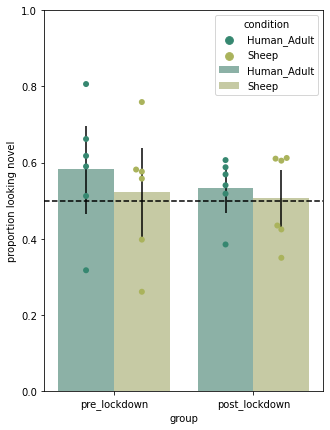

In [9]:
np.random.seed(0)

# preset 
values=[]
groups=[]
conditions=[]
sub_ages=[]

# set up the figure
fig=plt.figure(figsize=(5,7))

# what are the group indices?
group_idxs=[pre_idxs,post_idxs]

# cycle through groups and conditions 
for i, group in enumerate(['pre_lockdown','post_lockdown']):
    for c, condition in enumerate(['Human_Adult','Sheep']):
        
        behavior_all=[]
        
        # cycle through participants
        for ppt in df.ppt[group_idxs[i]]:
            data_file = '%s/%s.mat' %(behav_dir,ppt)
            behavior_mat = loadmat(data_file, struct_as_record=False)
            
            # only get the repeat blocks for this condition (2 or 3 blocks)
            repeat_idxs=[i for i,j in enumerate(behavior_mat['Block_Names'][0]) if condition+'; Repeated' in j[0]]

            all_proportion_novel=[]
            
            # cycle through blocks and get the timing information 
            for idx in repeat_idxs:
                timecourse=behavior_mat['Timecourse_all'][0][idx][0]
                vpc_onset=behavior_mat['VPCOnsets'][0][idx][0][0]
                vpc_offset=behavior_mat['VPCOffsets'][0][idx][0][0]
                
                # looking behavior just during the vpc
                vpc_timecourse=timecourse[vpc_onset:vpc_offset]

                if behavior_mat['Novel_Sides'][0][idx][0] == 'left':
                    novel_side=1 # key code for left
                    familiar_side=2 # key code for right
                elif behavior_mat['Novel_Sides'][0][idx][0] == 'right':
                    novel_side=2 # key code for right
                    familiar_side=1 # key code for left

                # only add the behavioral data if this was useable in fMRI analysis
                if behavior_mat['Included_TRs'][0][idx]>0.5:
                    
                    # calculate proportion looking to novel
                    proportion_novel=np.sum(vpc_timecourse==novel_side)/(np.sum(vpc_timecourse==familiar_side)
                                                       +np.sum(vpc_timecourse==novel_side))
                    all_proportion_novel.append(proportion_novel)

            #print(ppt,np.nanmean(all_proportion_novel))
            behavior_all.append(np.nanmean(all_proportion_novel))
            
            sub_ages.append(float(df.Age[df.ppt==ppt]))
        
        # save out the information for plotting 
        values.extend(behavior_all)
        groups.extend(np.repeat(group,len(behavior_all)))
        conditions.extend(np.repeat(condition,len(behavior_all)))
        
        # statistics
        pval,CIs=bootstrap_mean(behavior_all,null_vall=0.5,nPerm=1000)
        print('%s %s: %0.3f [%0.3f,%0.3f], p=%0.3f' %(group, condition, np.mean(behavior_all),CIs[0],CIs[1],pval))
        
        # add the error bars for our calcuation of bootstrapping
        low_err=np.abs(np.mean(behavior_all)-CIs[0])
        high_err=np.abs(np.mean(behavior_all)-CIs[1])

        if c==0:
            xval=[(i-0.2)]
        else:
            xval=[(i-0.2*(-c))]
            
        plt.errorbar(xval,
             np.nanmean(behavior_all),
                     yerr=np.expand_dims(np.array([low_err,high_err]),1),fmt='none',ecolor='k') #use our CI

# make df for plotting
df_rep_condition=pd.DataFrame({'group':groups,'condition':conditions,'proportion looking novel':values,'sub age':sub_ages})

# plot! 
color='gist_earth'
sns.barplot(x='group',y='proportion looking novel',hue='condition',data=df_rep_condition,
            orient='v',ci=False,alpha=0.6,palette=color)
sns.swarmplot(x='group',y='proportion looking novel',hue='condition',data=df_rep_condition,dodge=True,palette=color,size=6)
plt.axhline(0.5,linestyle='--',color='k')
plt.ylim(0,1)

# save out the plot 
fig.savefig(save_plot_dir+'behavioral_results.svg')


In [10]:
# What is the difference between the two groups?
np.random.seed(0)
for c, condition in enumerate(['Human_Adult','Sheep']):
    
    pre_values=np.array(df_rep_condition[(df_rep_condition.group=='pre_lockdown')*
                          (df_rep_condition.condition==condition)]['proportion looking novel'])

    post_values=np.array(df_rep_condition[(df_rep_condition.group=='post_lockdown')*
                          (df_rep_condition.condition==condition)]['proportion looking novel'])
    
    pval,mean_diff,_=randomise_diff_2sample(pre_values,
                           post_values)
    print('Difference in prop looking novel during %s: mean_diff=%0.3f, pval=%0.3f' %(condition,mean_diff,pval))        
    

Difference in prop looking novel during Human_Adult: mean_diff=0.050, pval=0.466
Difference in prop looking novel during Sheep: mean_diff=0.016, pval=0.848


## Human face processing in infant FFA  <a id='looFFA'></a>

Using the FFA as our search space, find the top 5% of voxels in all but one participant for the contrast of human novel blocks vs. scene blocks. Then, find the zstat values for human novel blocks, human repeat blocks, and the contrast between them in those voxels for the held out participant. Finally, plot the results, separating pre and post lockdown group.

In [11]:
# Load in the bilateral FFA mask that will be our search space
roi_mask=nib.load('%s/intersect_%s.nii.gz' % (roi_dir,'bilateral_FFA'))
roi_masker=NiftiMasker(roi_mask)
roi_masker.fit(roi_mask)

# What proportion of voxels in the FFA search space will you take? (Based on the highest face > scene contrast)
prop_voxels=0.05 # 5% of the voxels 

# presets
loo_values=[]
age_groups=[]
zstats_values=[]
betas_used=[]
voxels_used=np.zeros(roi_mask.shape)

# presets for the results
all_results=np.zeros((2,6,2)) # 2 groups x 6 subs x 2 contrasts (Just the Novel and Repeat)
difference_values=np.zeros((2,6)) # 2 groups x 6 subs # This will be where we store the zstats of the contrast (zstat=1)

# what are the group indices?
group_idxs=[pre_idxs,post_idxs]

for i, group in enumerate(['pre_lockdown','post_lockdown']):

    ppt_results=[]
    for p, ppt in enumerate(df.ppt[group_idxs[i]]):

        # get the merged nii 
        nii = nib.load('%s/%s_merged_scene_face_zstat1.nii.gz' % (loo_dir, ppt))
        masked=roi_masker.fit_transform(nii)*-1 # multiply by 1 so high values mean high face > scene 
        masked=np.nanmean(masked,axis=0) # Average over all other subjects 
        
        # take the top percent of indices
        top_indices=np.argsort(masked)[-round(len(masked)*prop_voxels):] 

        top_masked=np.zeros(masked.shape[0])
        top_masked[top_indices]=1
        
        # save which voxels were used in this analysis, keeping their spatial coordinates
        voxels_used+=roi_masker.inverse_transform(top_masked).get_fdata()

        # save the beta values as well 
        top_betas=masked[top_masked==1]
        betas_used+=[top_betas]

        for z, zstat in enumerate(zstats):

            nii=nib.load('%s/%s_%s_zstat%d.nii.gz' %(zstat_dir,ppt,'human_pairs',zstat))
            heldout_betas=roi_masker.fit_transform(nii)[0,top_masked==1]
            
            # if it is not zstat 1, we save the values for plotting
            if zstat!=1:
                # append for plotting purposes
                loo_values.append(np.nanmean(heldout_betas))
                age_groups.append(group)
                zstats_values.append(zstat)
            
                all_results[i,p,z]=np.nanmean(heldout_betas)
            
            # if it is zstat 1 (the contrast of novel and repeat), we will save elsewhere
            # so it can be used for statistical testing
            else: 
                difference_values[i,p]=np.nanmean(heldout_betas)
                
# make df for plotting purposes
loo_df=pd.DataFrame({'values':loo_values,'zstat':zstats_values,'lockdown_group':age_groups})

pre_lockdown novel: 1.185
pre_lockdown repeat: 0.588
pre_lockdown Human novel > repeated: 0.749 (-0.096 -- 1.648), p=0.088

post_lockdown novel: 1.067
post_lockdown repeat: 1.705
post_lockdown Human novel > repeated: -0.749 (-1.522 -- -0.009), p=0.040

Difference across groups: 1.499 (0.349 -- 2.701), p=0.006


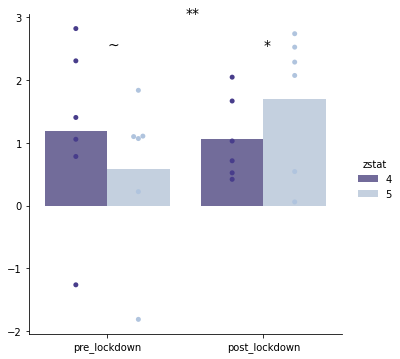

In [12]:
np.random.seed(0)
show_lines=0 # do you want to show lines connecting the Repeat and Novel block values for the same subjects?

# plot
g = sns.catplot(x='lockdown_group',y='values',hue='zstat',data=loo_df,kind='bar',legend=True,
                palette=colors[:,0], 
                alpha=0.8,ci=False)
g.map_dataframe(sns.swarmplot, x='lockdown_group',y='values',hue='zstat', 
                dodge=True,palette=colors[:,0])

# if show lines is 1, connects the points in the novel and repeat plots for each subject
if show_lines==1:

    for i in [0,1]:
        for sub in range(all_results[i,:,:].shape[0]):
            plt.plot([-0.2+i,0.2+i],[all_results[i,sub,0],all_results[i,sub,1]],color="silver")

# report statistics within group
for i, group in enumerate(['pre_lockdown','post_lockdown']):
    for z, contrast in enumerate(['novel','repeat']): 
        
        # first, tell us about the means for the different contrasts
        print('%s %s: %0.3f' % (group,contrast,np.nanmean(all_results[i,:,z])))
    
    # then use the zstat for the contrast (zstat=1) for statistics
    pval,CIs=bootstrap_mean(np.array(difference_values[i,:]))
    print('%s %s: %0.3f (%0.3f -- %0.3f), p=%0.3f' % (group,'Human novel > repeated',
                                                      np.nanmean(np.array(difference_values[i,:])),
                                                      CIs[0],CIs[1],pval))
    draw_sig(pval,1,i,2.5)
    print()
    
# what is the difference across groups? (using the zstat for the contrast)
pval, mean_diff, CIs=randomise_diff_2sample(np.array(difference_values[0,:]), 
                                            np.array(difference_values[1,:]), 
                                            resample_num=10000)
print('Difference across groups: %0.3f (%0.3f -- %0.3f), p=%0.3f' %(mean_diff,CIs[0],CIs[1],pval))
draw_sig(pval,1,0.5,3)
    
g.savefig(save_plot_dir+'loo_bilateral_FFA_results.svg')


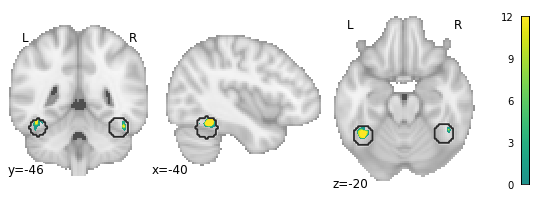

In [13]:
# Show which voxels were used in this analysis 
voxels_nifti=nib.Nifti1Image(voxels_used,roi_mask.affine)
fig=plotting.plot_stat_map(voxels_nifti,draw_cross=False,cut_coords=(-40,-46,-20),cmap='viridis')

fig.add_contours(roi_mask,alpha=0.8,cmap='Greys')

fig.savefig(save_plot_dir+'loo_bilateral_FFA_voxels.svg')

## Human face processing in broader ROIs <a id='human'></a>

Finds and plots the zstat values for human novel blocks, human repeat blocks, and the contrast between them, using all voxels that make up different ROIs from the face processing meta-analysis retrieved from https://neurosynth.org/

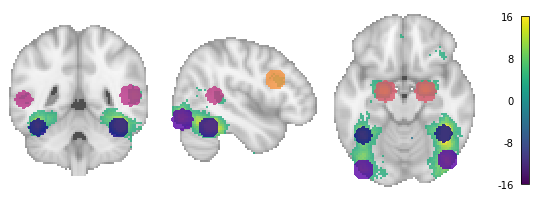

In [14]:
# upload the meta analysis roi 
meta_analysis=nib.load('%s/face_association-test_z_FDR_0.01.nii.gz' %roi_dir)

# plot the meta analysis results
fig=plotting.plot_stat_map(meta_analysis,draw_cross=False,cmap=plt.get_cmap('viridis'),
                           cut_coords=(45,-45,-16),annotate=False,alpha=0.8,colorbar=True,vmax=16)

# load the file that has all of the rois so the color palette works out 
all_rois = nib.load('%s/face_association_all_rois.nii.gz'%roi_dir) 
fig.add_contours(all_rois,cmap='plasma',alpha=0.8,threshold=0,filled=True,vmax=120)


Loading files for face rois with human_pairs contrast (may take some time)
Loaded bilateral_FFA
Loaded bilateral_OFA
Loaded bilateral_STS
Loaded bilateral_Amyg
Loaded rIFG_mask_1mm

bilateral_FFA
pre_lockdown: Novel > Repeat : 0.574 (-0.136 -- 1.282), p=0.124
post_lockdown: Novel > Repeat : -0.751 (-1.337 -- -0.207), p=0.004
Difference across groups: 1.325 (0.414 -- 2.279), p=0.004

bilateral_OFA
pre_lockdown: Novel > Repeat : 0.548 (-0.246 -- 1.371), p=0.202
post_lockdown: Novel > Repeat : -0.397 (-1.024 -- 0.119), p=0.152
Difference across groups: 0.946 (-0.024 -- 2.020), p=0.058

bilateral_STS
pre_lockdown: Novel > Repeat : 0.041 (-0.765 -- 0.727), p=0.846
post_lockdown: Novel > Repeat : -1.211 (-1.859 -- -0.570), p=0.000
Difference across groups: 1.251 (0.231 -- 2.300), p=0.018

bilateral_Amyg
pre_lockdown: Novel > Repeat : 0.481 (-0.245 -- 1.084), p=0.202
post_lockdown: Novel > Repeat : -0.189 (-0.792 -- 0.383), p=0.552
Difference across groups: 0.670 (-0.245 -- 1.572), p=0.157

r

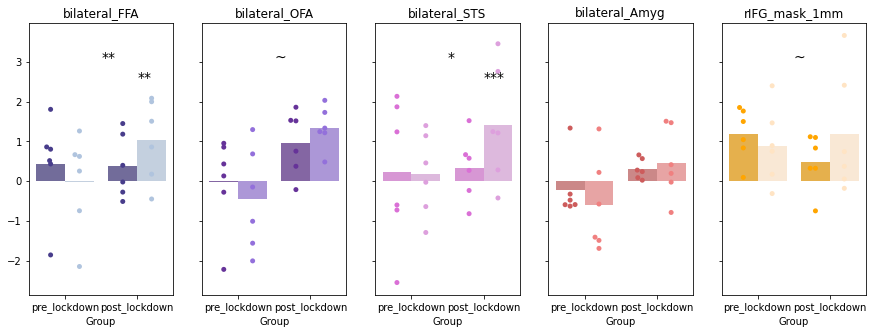

In [15]:
# Run the analysis 
roi_results_human=roi_results_wrapper(temp_rois=rois,temp_colors=colors,
                                      roi_group='face',glm_contrast='human_pairs',plot=True)

Now, find and plot the zstat values for human novel blocks, human repeat blocks, and the contrast between them, using all voxels that make up different ROIs from two sensory meta-analyses: primary visual cortex and heschl's gyrus (primary auditory cortex)

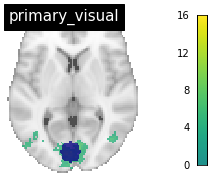

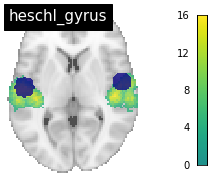

In [16]:
# cycle through the other roi types 
for meta_name, roi_name in zip(['primary_visual','heschl_gyrus'],control_rois):
    meta_analysis=nib.load('%s/%s_association-test_z_FDR_0.01.nii.gz' %(roi_dir,meta_name))

    # plot the meta analysis results
    fig=plotting.plot_stat_map(meta_analysis,draw_cross=False,cmap=plt.get_cmap('viridis'),
                               display_mode='z',cut_coords=[4],annotate=False,alpha=0.8,
                               colorbar=True,vmax=16,title=meta_name)

    # load the file that has the spheres
    all_rois = nib.load('%s/%s.nii.gz'%(roi_dir,roi_name)) 
    fig.add_contours(all_rois,cmap='plasma',alpha=0.8,threshold=0,filled=True,vmax=120)

Loading files for sensory rois with human_pairs contrast (may take some time)
Loaded V1_sphere_1mm
Loaded bilateral_A1

V1_sphere_1mm
pre_lockdown: Novel > Repeat : 0.860 (0.250 -- 1.482), p=0.006
post_lockdown: Novel > Repeat : -0.512 (-1.449 -- 0.293), p=0.334
Difference across groups: 1.372 (0.308 -- 2.547), p=0.009

bilateral_A1
pre_lockdown: Novel > Repeat : 0.104 (-0.930 -- 1.115), p=0.862
post_lockdown: Novel > Repeat : -0.735 (-1.539 -- 0.004), p=0.054
Difference across groups: 0.839 (-0.449 -- 2.155), p=0.218



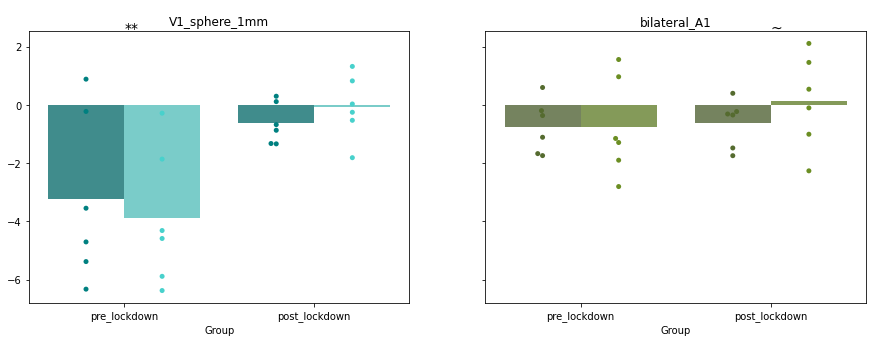

In [17]:
# Run the analysis 
control_roi_results_human=roi_results_wrapper(temp_rois=control_rois,temp_colors=control_colors,
                    roi_group='sensory',glm_contrast='human_pairs',plot=True)

## Sheep face processing in broader ROIs <a id='sheep'></a>

Finds and plots the zstat values for sheep novel blocks, sheep repeat blocks, and the contrast between them, using all voxels that make up different ROIs from the face processing meta-analysis

Loading files for face rois with sheep_pairs contrast (may take some time)
Loaded bilateral_FFA
Loaded bilateral_OFA
Loaded bilateral_STS
Loaded bilateral_Amyg
Loaded rIFG_mask_1mm

bilateral_FFA
pre_lockdown: Novel > Repeat : 1.120 (0.622 -- 1.625), p=0.000
post_lockdown: Novel > Repeat : 0.052 (-0.702 -- 1.013), p=0.962
Difference across groups: 1.067 (-0.030 -- 1.995), p=0.054

bilateral_OFA
pre_lockdown: Novel > Repeat : 0.845 (0.518 -- 1.087), p=0.000
post_lockdown: Novel > Repeat : 0.094 (-0.510 -- 0.773), p=0.798
Difference across groups: 0.751 (0.001 -- 1.451), p=0.049

bilateral_STS
pre_lockdown: Novel > Repeat : 0.023 (-0.456 -- 0.563), p=0.956
post_lockdown: Novel > Repeat : 0.121 (-0.519 -- 0.817), p=0.752
Difference across groups: -0.098 (-0.954 -- 0.731), p=0.837

bilateral_Amyg
pre_lockdown: Novel > Repeat : 0.024 (-0.461 -- 0.562), p=0.968
post_lockdown: Novel > Repeat : 0.178 (-0.380 -- 0.801), p=0.596
Difference across groups: -0.154 (-0.930 -- 0.612), p=0.695

rIFG_m

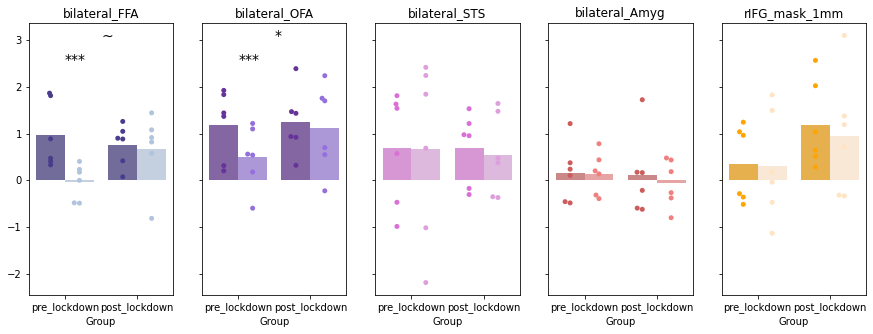

In [18]:
# Run the analysis 
face_roi_results_sheep=roi_results_wrapper(temp_rois=rois,temp_colors=colors,
                    roi_group='face',glm_contrast='sheep_pairs',plot=True)

Now, find and plot the zstat values for sheep novel blocks, sheep repeat blocks, and the contrast between them, using all voxels that make up different ROIs from two sensory meta-analyses: primary visual cortex and heschl's gyrus (primary auditory cortex)

Loading files for sensory rois with sheep_pairs contrast (may take some time)
Loaded V1_sphere_1mm
Loaded bilateral_A1

V1_sphere_1mm
pre_lockdown: Novel > Repeat : 0.157 (-0.395 -- 0.675), p=0.574
post_lockdown: Novel > Repeat : -0.038 (-0.916 -- 0.840), p=0.996
Difference across groups: 0.195 (-0.846 -- 1.263), p=0.699

bilateral_A1
pre_lockdown: Novel > Repeat : -0.852 (-1.564 -- -0.021), p=0.038
post_lockdown: Novel > Repeat : -0.119 (-0.733 -- 0.479), p=0.786
Difference across groups: -0.733 (-1.663 -- 0.247), p=0.138



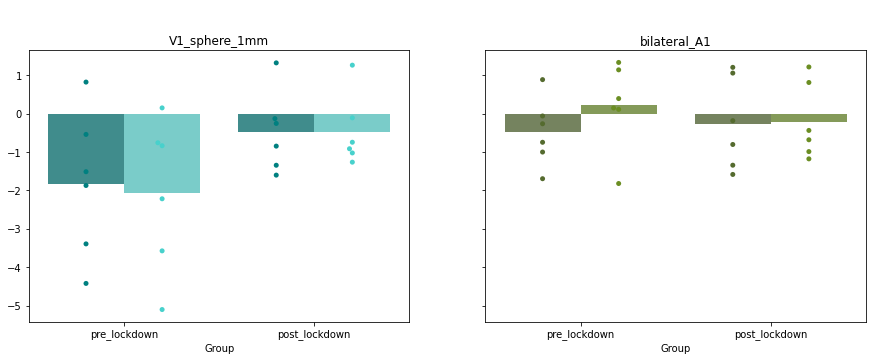

In [19]:
# run the analysis 
control_roi_results_human=roi_results_wrapper(temp_rois=control_rois,temp_colors=control_colors,
                    roi_group='sensory',glm_contrast='sheep_pairs',plot=True)